In [1]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
############### upload data
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd

path ='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data/test.csv'

text_data = pd.read_csv(path, sep=',')
print(text_data)

                    id  ... identity_hate
0     21cb9147466a97d9  ...             0
1     e5cc96a965a9477c  ...             0
2     48cf4e824ff9ab27  ...             0
3     e1828969a07a48bd  ...             0
4     a0b2f29fec82305f  ...             0
...                ...  ...           ...
3241  95eda78799f2f83c  ...             0
3242  f0bf335ca4522653  ...             1
3243  2039c94121e73102  ...             0
3244  4f8662c6f69546ee  ...             0
3245  b2f2fc2fd961d836  ...             0

[3246 rows x 8 columns]


In [22]:
############## train function and accuracy function
import matplotlib.pyplot as plt

def get_accuracy(net,dataloader):
    seed = 1
    torch.manual_seed(seed)
    lossfunction = torch.nn.BCEWithLogitsLoss()  
    running_loss = 0.0
    train_correct= 0
    total_data= 0
    acc = 0
    for i, data in enumerate(dataloader, 0):
          inputs,inputs_length = data.text
          labels = data.label.float()

          # forward + backward + optimize
          outputs = net(inputs,inputs_length)
          # print(outputs)
          loss = lossfunction(outputs, labels)
          
          running_loss += loss.item()
          # print('vali--running_loss',running_loss)


          # calculate train accuracy
          outputs = (outputs>0.5).float()
          train_correct += (outputs == labels).sum().item()
          # calculate total number of data
          total_data += labels.size(0)
          # print('total_data',total_data)
          # print('train_correct',train_correct)
          acc = train_correct/total_data
    
    # print('---------vali--running_loss',running_loss)
    return running_loss/(i+1),acc


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
import os
import datetime, time

In [9]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 100,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 1
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        # print('x1 = x1.squeeze(3)',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1) #maxpool
        
        x = pool1(x1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        x = x.squeeze(2)
        x = x.unsqueeze(0)
        # print('x = x.squeeze(2)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        h_result = self.fc1(h.squeeze(0))
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        

        return h_result.squeeze(1)

In [30]:
def trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 25, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50):


  torch.manual_seed(seed)
    
  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  # TOXIC           = data.Field(sequential=False, use_vocab=False)
  # SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  # THREAT          = data.Field(sequential=False, use_vocab=False)
  # INSULT          = data.Field(sequential=False, use_vocab=False)
  # IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
          path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/processed_data/binary', train='binary_train.csv',
          validation='binary_valid.csv', test='binary_test.csv', format='csv',
          skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', None), ('severe_toxic', None), ('label', OBSCENE), ('threat', None), ('insult', None), ('identity_hate', None)])
          # COMMENT_TEXT
  train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size,batch_size),
      sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

  COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

  COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
  vocab = COMMENT_TEXT.vocab

  model = model(emb_dim, vocab)
  # model = model(vocab)

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  lossCount = []
  valLossCount = []
  accCount = []
  valAccCount = []
  testLossCount = []
  testAccCount = []
  epochCount = []
  
  for epoch in range(epochs):  # loop over the dataset multiple times
      correct = 0
      total = 0
      runningLoss = 0.0
      numberOfBatches = 0
      valCorrect = 0
      valRunningLoss = 0.0
      valNumberOfBatches = 0
      valTotal = 0
      for i, batch in enumerate(train_iter, 0):
          # get the set of text sentences in the batch and length of the sentence sequences
          batch_input, batch_input_length = batch.text
          labels = batch.label.float()    
      
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          
          # evaluate training accuracy
          with torch.no_grad():
            outputs = (outputs>0.5).float()
            correct += (outputs == labels).sum().item()
          
          # add training loss
          runningLoss += loss.item()

          # count the number of batches and samples
          numberOfBatches += 1
          total += labels.size(0)



      # evaluate validation loss and 
      with torch.no_grad():
        for batch in val_iter:
          batch_input, batch_input_length = batch.text
          labels = batch.label.float()    
          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          valRunningLoss += loss.item()
          outputs = (outputs>0.5).float()
          valCorrect += (outputs == labels).sum().item()
          valTotal += labels.size(0)
          valNumberOfBatches += 1


      runningLoss = runningLoss/numberOfBatches
      correct = correct/total
      valRunningLoss = valRunningLoss/valNumberOfBatches
      valCorrect = valCorrect/valTotal
      # print statistics for every epoch)
      print('[%d] train loss: %.3f, train acc: %.3f, validation loss: %.3f, validation acc: %.3f ' %
                    (epoch + 1, runningLoss, correct, valRunningLoss, valCorrect))
      lossCount += [runningLoss]
      accCount += [correct]
      epochCount += [epoch+1]
      valLossCount += [valRunningLoss]
      valAccCount += [valCorrect]

      

  testCorrect = 0
  testRunningLoss = 0.0
  testNumberOfBatches = 0
  testTotal = 0
  with torch.no_grad():
        for batch in test_iter:
          batch_input, batch_input_length = batch.text
          labels = batch.label.float()    
          outputs = model(batch_input, batch_input_length)
          loss = criterion(outputs, labels)
          testRunningLoss += loss.item()
          outputs = (outputs>0.5).float()
          testCorrect += (outputs == labels).sum().item()
          testTotal += labels.size(0)
          testNumberOfBatches += 1
        testRunningLoss = testRunningLoss/testNumberOfBatches
        testLossCount += [testRunningLoss]
        testAccCount += [testCorrect]
  print('Finished Training. Test accuracy is %.3f and loss is %.3f' % (testCorrect/testTotal, testRunningLoss))

  #plot
  plt.title("Loss Curve")
  plt.plot(epochCount, lossCount, label="Training")
  plt.plot(epochCount, valLossCount, label="Validation")
  # plt.plot(epochCount, testLossCount, label="Testing")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


  plt.title("Accuracy Curve")
  plt.plot(epochCount, accCount, label = "Training")
  plt.plot(epochCount, valAccCount, label = "Validation")
  # plt.plot(epochCount, testAccCount, label="Testing")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  torch.save(model,'model_rnn.pt')

[1] train loss: 0.570, train acc: 0.845, validation loss: 0.537, validation acc: 0.929 
[2] train loss: 0.532, train acc: 0.937, validation loss: 0.534, validation acc: 0.921 
[3] train loss: 0.528, train acc: 0.944, validation loss: 0.532, validation acc: 0.936 
[4] train loss: 0.525, train acc: 0.952, validation loss: 0.530, validation acc: 0.938 
[5] train loss: 0.523, train acc: 0.955, validation loss: 0.530, validation acc: 0.941 
[6] train loss: 0.521, train acc: 0.959, validation loss: 0.530, validation acc: 0.941 
[7] train loss: 0.520, train acc: 0.963, validation loss: 0.529, validation acc: 0.936 
[8] train loss: 0.519, train acc: 0.965, validation loss: 0.529, validation acc: 0.944 
[9] train loss: 0.518, train acc: 0.966, validation loss: 0.529, validation acc: 0.934 
[10] train loss: 0.518, train acc: 0.967, validation loss: 0.528, validation acc: 0.946 
[11] train loss: 0.515, train acc: 0.972, validation loss: 0.532, validation acc: 0.942 
[12] train loss: 0.515, train 

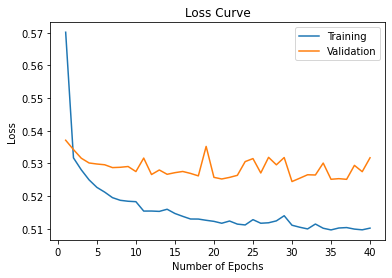

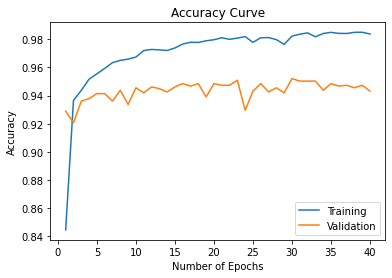

In [32]:
trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 40, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)